In [60]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import re
import Levenshtein
from collections import Counter

In [69]:
webmd = pd.read_csv('webmd.csv')

In [71]:
#preprocessing, lowercase set
for colName in ['Drug','Condition','Reviews','Sides','Sex']:
    webmd[colName] = webmd[colName].str.lower()
#merge duplicate drugs with same Ids but different string names, some duplicate row issues under different name
for drugId in set(webmd['DrugId'].tolist()):
    drugs = set(webmd[webmd['DrugId']==drugId]['Drug'].tolist())
    if len(drugs)>1:#more than one drug under same id
        merge = min(drugs, key=len)
        webmd.loc[webmd['DrugId']==drugId, 'Drug'] = merge
    
webmd = webmd.drop_duplicates()

In [72]:
webmd.head()

Age      Condition       Date                          Drug  DrugId  \
0  75 or over    stuffy nose  9/21/2014                  25dph-7.5peh  146724   
1       25-34  cold symptoms  1/13/2011                  25dph-7.5peh  146724   
2       65-74          other  7/16/2012  warfarin (bulk) 100 % powder  144731   
3  75 or over          other  9/23/2010  warfarin (bulk) 100 % powder  144731   
4       35-44          other   1/6/2009  warfarin (bulk) 100 % powder  144731   

   EaseofUse  Effectiveness  \
0          5              5   
1          5              5   
2          2              3   
3          2              2   
4          1              1   

                                             Reviews  Satisfaction     Sex  \
0  i'm a retired physician and of all the meds i ...             5    male   
1  cleared me right up even with my throat hurtin...             5  female   
2  why did my ptinr go from a normal of 2.5 to ov...             3  female   
3                       falling and don't realise it             1  female   
4  my grandfather was prescribed this medication ...             1    male   

                                               Sides  UsefulCount  
0  drowsiness,  dizziness ,  dry mouth /nose/thro...            0  
1  drowsiness,  dizziness ,  dry mouth /nose/thro...            1  
2                                                               0  
3                                                               0  
4                                                               1

In [74]:
#Set of unique conditions identified in reviews and drugs reviewed in dataset. 
conditions = set(webmd['Condition'].tolist())
drugs = set(webmd['Drug'].tolist())

In [73]:
len(set(webmd['DrugId'].tolist()))

6572

In [75]:
print(len(conditions))
print(len(drugs))

1806
6572


In [76]:
#Nodes to represent drugs in network
drugNodes = []
for drugName in drugs:
    node = (drugName, {'type':'drug'})
    drugNodes += [node]

In [77]:
#Nodes to represent conditions in network
conditionNodes = []
for conditionName in conditions:
    node = (conditionName, {'type':'condition'})
    conditionNodes += [node]

In [78]:
nodes = drugNodes + conditionNodes

In [79]:
#Create edge list that connects drugs with conditions they are identified as used for in review
edgeList = []
for drug in drugs:
    rows = webmd[webmd['Drug'] == drug]
    condList = set(rows['Condition'].tolist())#TODO, take into account # of reviews for each condition for width
    for condition in condList:
        edge = (drug, condition)
        edgeList+= [edge]

In [80]:
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edgeList)

In [81]:
node_type_color = ['r' if G.nodes[n]['type'] == 'drug' else 'b' for n in G.nodes]

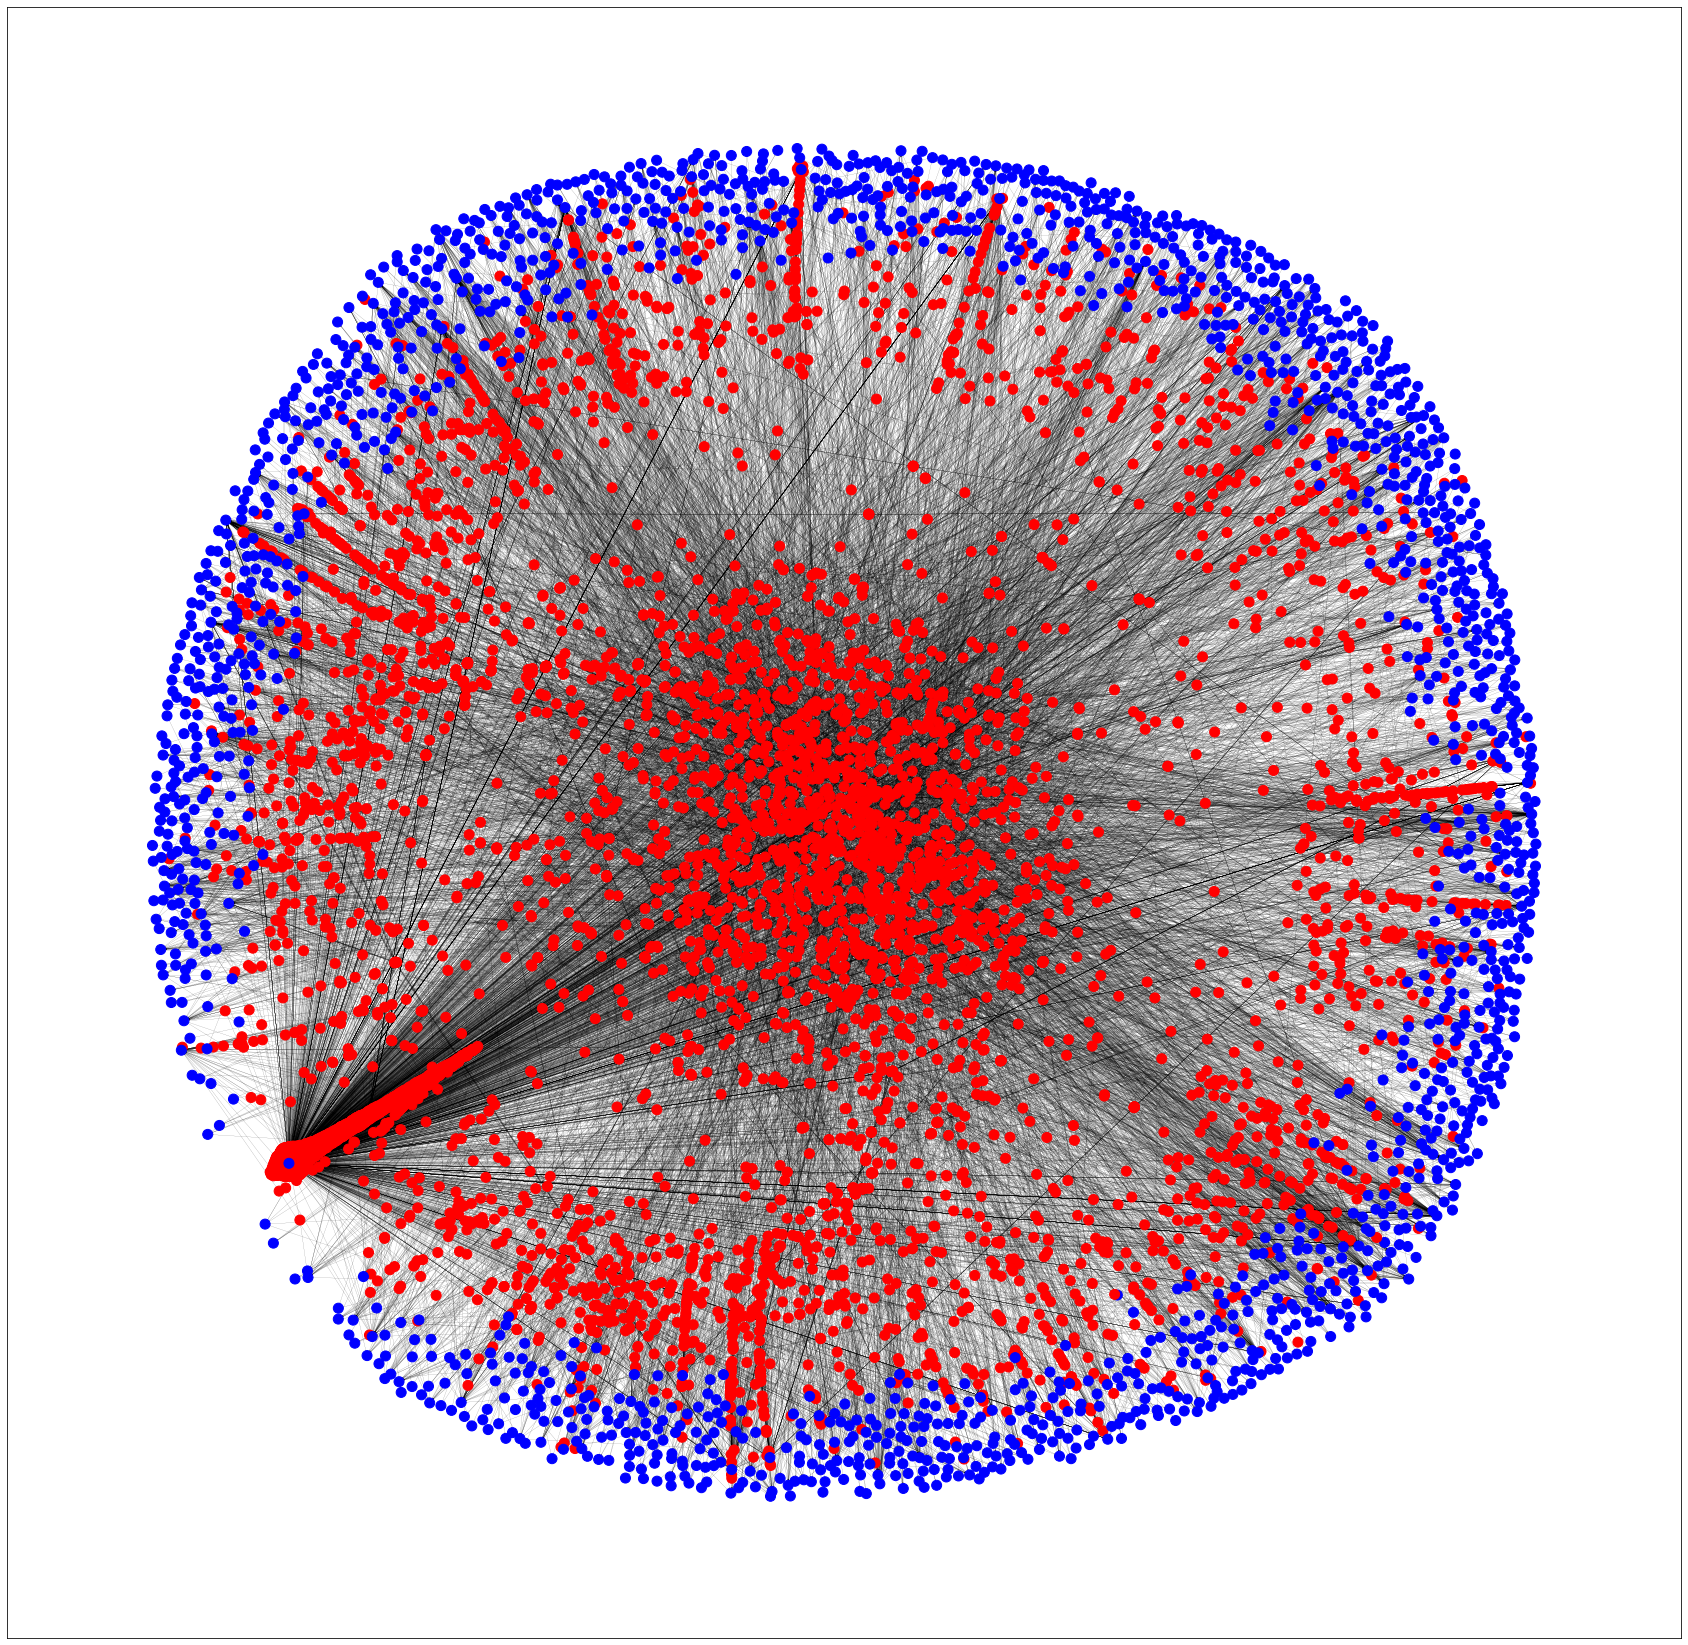

In [87]:
plt.figure(figsize = (30, 30)) 
pos = nx.spring_layout(G) 
nx.draw_networkx(G, pos, node_color = node_type_color, with_labels = False, node_size = 100, arrowsize=1, width = .1 )
plt.show()

In [83]:
#Which drugs have been reviewed for the most differnet conditions
Counter(nx.out_degree_centrality(G)).most_common(20)

[('prednisone', 0.0109863864342011),
 ('cipro', 0.007045617387150704),
 ('methylprednisolone', 0.006209696680200621),
 ('ciprofloxacin', 0.005732027704800574),
 ('levaquin', 0.00549319321710055),
 ('kenalog-40 vial', 0.0051349414855505135),
 ('doxycycline hyclate tablet tetracyclines', 0.005015524241700502),
 ('azithromycin', 0.004776689754000478),
 ('metronidazole', 0.004657272510150466),
 ('levofloxacin', 0.004418438022450442),
 ('doxycycline calcium syrup', 0.00429902077860043),
 ('bactrim ds', 0.0040601862909004065),
 ('clarithromycin', 0.0040601862909004065),
 ('dexamethasone', 0.0040601862909004065),
 ('medrol tablet', 0.0040601862909004065),
 ('amoxicillin', 0.0040601862909004065),
 ('medrol', 0.0040601862909004065),
 ('flagyl', 0.0040601862909004065),
 ('clindamycin hcl', 0.0037019345593503703),
 ('prednisolone', 0.0037019345593503703)]

In [84]:
#Which conditions are identified as being reviewed for the most
Counter(nx.in_degree_centrality(G)).most_common(20)

[('other', 0.4856699307379986),
 ('osteoporosis', 0.025674707427752567),
 ('birth control', 0.02340577979460234),
 ('high blood pressure', 0.021733938380702172),
 ('acne', 0.021256269405302126),
 ('pain', 0.020778600429902077),
 ('painful periods', 0.016837831382851685),
 ('cough', 0.015763076188201577),
 ('cold symptoms', 0.014927155481251493),
 ('rheumatoid arthritis', 0.01468832099355147),
 ('type 2 diabetes mellitus', 0.013255314067351327),
 ('abnormally long or heavy periods', 0.013016479579651302),
 ('inflammation of the nose due to an allergy', 0.013016479579651302),
 ('incomplete or infrequent bowel movements', 0.012658227848101266),
 ('stuffy nose', 0.012419393360401243),
 ('disease of ovaries with cysts', 0.01170288989730117),
 ('allergic conjunctivitis', 0.011105803678051111),
 ('migraine headache', 0.00979221399570098),
 ('anemia from inadequate iron', 0.009672796751850968),
 ('endometriosis', 0.009075710532600909)]